In [1]:
from typing import Tuple, List, Dict

from qiskit import QuantumCircuit
from qiskit.circuit.library import QAOAAnsatz
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

from qiskit_aer import AerSimulator
from qiskit_aer.primitives import EstimatorV2, SamplerV2

from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt

In [2]:
N = 5 # the side of the board

In [3]:
Cell = Tuple[int, int]
def get_attacks_for_each_cell(cell:Cell) -> List[Cell]:
    """
    Check the attacks for each queen position.
    """

    current_row, current_col = cell

    attacks = []


    for k in range(N):
        current_mapped_col = (k, current_col)
        current_mapped_row = (current_row, k)

        if current_mapped_row != cell:
            attacks.append(current_mapped_row)
        
        if current_mapped_col != cell:
            attacks.append(current_mapped_col)


    # top left
    current_i = current_row
    current_j = current_col
    while current_i > 0 and current_j > 0:
        current_i -= 1
        current_j -= 1
        attacks.append((current_i, current_j))

    # bottom right
    current_i = current_row
    current_j = current_col
    while current_i < N-1 and current_j < N-1:
        current_i += 1
        current_j += 1
        attacks.append((current_i, current_j))

    # top right 
    current_i = current_row
    current_j = current_col
    while current_i > 0 and current_j < N-1:
        current_i -= 1
        current_j += 1
        attacks.append((current_i, current_j))

    # bottom left 
    current_i = current_row
    current_j = current_col
    while current_i < N-1 and current_j > 0:
        current_i += 1
        current_j -= 1
        attacks.append((current_i, current_j))

    return attacks

In [4]:
Mapping = Dict[Cell, int]
def map_board_to_qubits() -> Mapping:
    mapping = {}
    qubit = 0
    for i in range(N):
        for j in range(N):
            mapping[(i,j)] = qubit
            qubit += 1
    return mapping

In [5]:
def get_H(mapping:Mapping, P:int) -> SparsePauliOp:
    obs = []

    total_qubits = N ** 2
    constants = -1 * (P*(total_qubits) - P*N)

    get_obs = lambda qubit : 'I'*qubit + 'Z' + 'I'*(total_qubits-qubit-1)


    for i in range(N):
        for j in range(N):
            pos = (i,j)

            attacks = get_attacks_for_each_cell(pos)

            for attack in attacks:
                qubit = mapping[attack]
                obs.append((get_obs(qubit), 1))

            constants += len(attacks)

            qubit = mapping[pos]
            obs.append((get_obs(qubit), -1 * P))

    obs.append(('I'*total_qubits, constants))
    return SparsePauliOp.from_list(obs)
    



In [6]:
qubits_mapping = map_board_to_qubits()

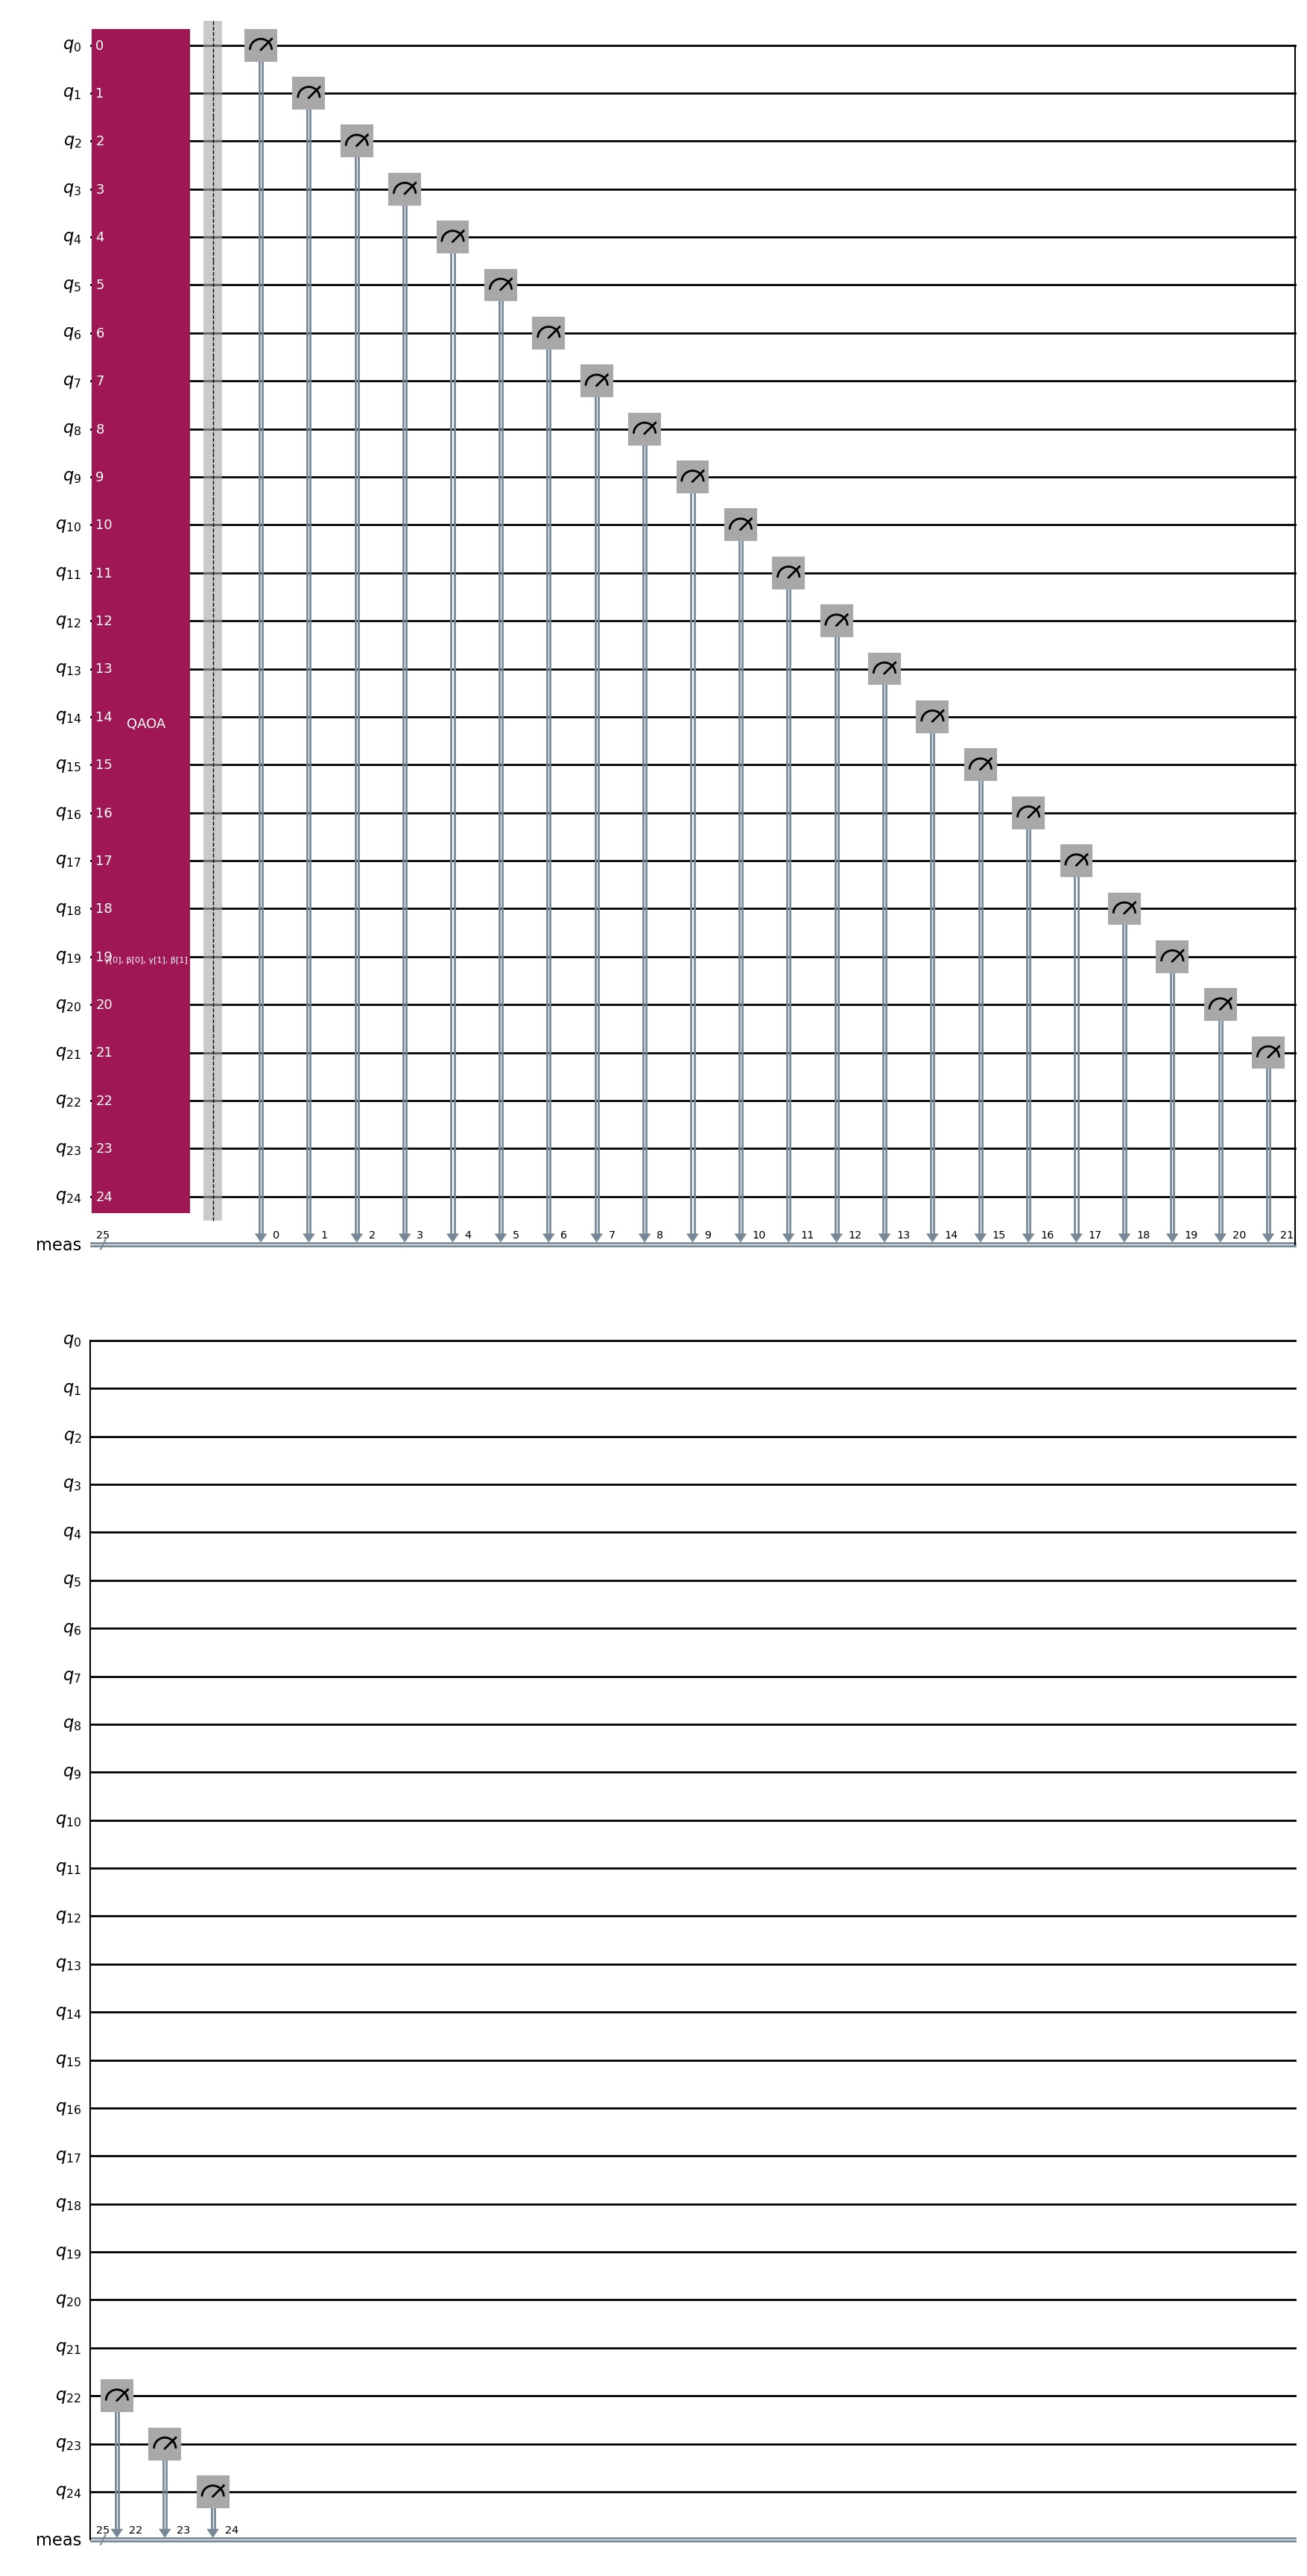

In [7]:
H = get_H(qubits_mapping, P=10)

qaoa = QAOAAnsatz(cost_operator=H,reps=2)
qaoa.measure_all()

qaoa.draw('mpl')

In [8]:
sim = AerSimulator()
pm = generate_preset_pass_manager(optimization_level=0, backend=sim)
isa_qc = pm.run(qaoa)

In [9]:
Params = List[float]
History = List[float]
def cost_func(params:Params, ansatz:QuantumCircuit, hamiltonian:SparsePauliOp, estimator:EstimatorV2, history:History) -> float:
    """Get the cost of the current circuit"""
    isa_h = hamiltonian.apply_layout(ansatz.layout)
    
    job = estimator.run([(ansatz, isa_h, params)])

    results = job.result()[0]
    cost = results.data.evs

    history.append(cost)
    print("Current cost: ", cost)

    return cost

In [ ]:
history = []
estimator = EstimatorV2()
init_params = np.random.uniform(low=0.0, high=np.pi, size=(1,len(isa_qc.parameters)))[0]
result = minimize(
        cost_func,
        init_params,
        args=(isa_qc, H, estimator, history),
        method="COBYLA",
        tol=1e-2,
    )

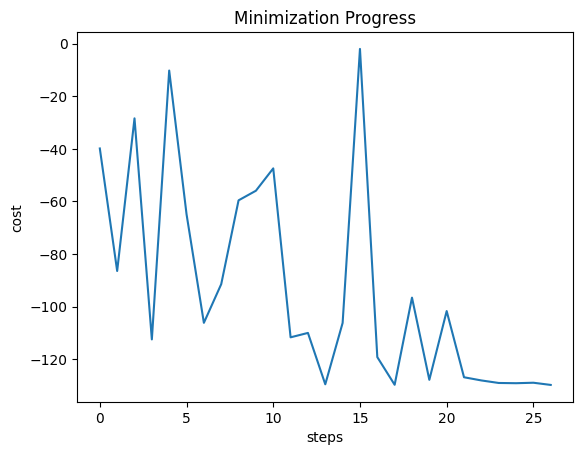

In [ ]:
plt.title("Minimization Progress")
plt.plot(list(range(len(history))), history)
plt.xlabel("steps")
plt.ylabel("cost")
plt.show()

In [ ]:
print(result.x)
answer_qc = isa_qc.assign_parameters(result.x)

[6.06165344 3.65332616 4.21636687 3.7538981 ]


In [ ]:
sampler = SamplerV2()
job = sampler.run([answer_qc], shots=1000)
bit_strings = job.result()[0].data.meas.get_counts()
bit_strings

{'0000000100000000': 6,
 '0000001000000000': 99,
 '0000000000000000': 239,
 '0000010000000000': 75,
 '0001000000000000': 2,
 '0000000000100000': 77,
 '0000000000000010': 4,
 '0000010000000010': 2,
 '0000011001100000': 10,
 '0000001011000000': 3,
 '0000010001000000': 29,
 '0000001001000000': 34,
 '0100000001100000': 2,
 '0000011000000000': 20,
 '0000001000100100': 1,
 '0000001000100000': 28,
 '0100000001000000': 1,
 '0100010000000000': 3,
 '0000000001000000': 74,
 '1001000001000000': 1,
 '0000001010000000': 4,
 '0000010000001000': 2,
 '0001001000100000': 1,
 '0001000000000100': 1,
 '0000010000100000': 23,
 '0000000001110000': 1,
 '0010000000000100': 1,
 '0000001100000000': 3,
 '0000011001000000': 12,
 '0000000001000001': 3,
 '0000001100100000': 1,
 '1000000000000000': 10,
 '0100001000000100': 1,
 '0000000101100000': 1,
 '0000011100000000': 2,
 '0000011000100100': 1,
 '0010011001000000': 1,
 '0000000011000000': 3,
 '0001000100100000': 1,
 '0000011000100000': 8,
 '0000000001100000': 27,
 

In [ ]:
def solution_board(bit_string:str):
    matrix = []

    qubit = 0
    for i in range(N):
        matrix.append([])
        for j in range(N):
            matrix[-1].append(int(bit_string[qubit]))
            qubit += 1
    
    plt.pcolormesh(matrix,edgecolors="k",linewidth=2)
    plt.show()

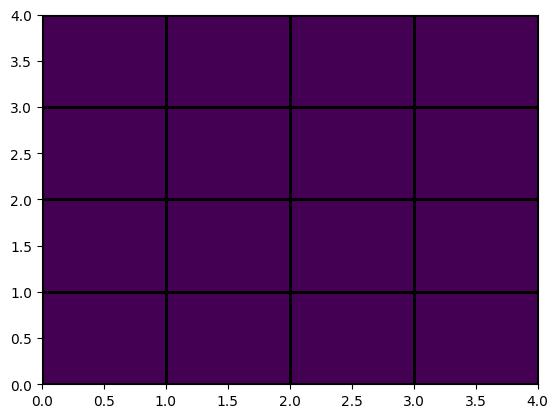

In [ ]:
best_solution = max(bit_strings.items(), key=lambda x: x[-1])[0]
solution_board(best_solution)